In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
# 读取BMP格式的图像文件
img = cv2.imread('./image1.bmp')

In [3]:
def rgb_to_hsi(rgb):
    # 解压缩RGB颜色分量
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]

    # 计算HSI空间中的颜色分量
    h, s, i = np.zeros_like(r), np.zeros_like(g), np.zeros_like(b)

    # 计算强度分量
    i = (r + g + b) / 3

    # 计算饱和度分量
    s = 1 - np.minimum(r, np.minimum(g, b)) / i
    s[i == 0] = 0

    # 计算色调分量
    theta = np.arccos((0.5 * ((r - g) + (r - b))) / (np.sqrt((r - g) ** 2 + (r - b) * (g - b))) + np.finfo(float).eps)
    h[b > g] = 2 * np.pi - theta[b > g]
    h[b <= g] = theta[b <= g]

    # 将HSI颜色分量合并为一个图像
    hsi = np.dstack((h, s, i))

    return hsi

In [4]:
def hsi_to_rgb(hsi):
    # 解压缩HSI颜色分量
    h, s, i = hsi[:, :, 0], hsi[:, :, 1], hsi[:, :, 2]

    # 计算RGB空间中的颜色分量
    r, g, b = np.zeros_like(h), np.zeros_like(h), np.zeros_like(h)

    # 通过三个条件判断将HSI颜色分量转换为RGB颜色分量
    # 计算RGB空间中的红色分量
    idx = (h < 2 * np.pi / 3)
    b[idx] = i[idx] * (1 - s[idx])
    r[idx] = i[idx] * (1 + s[idx] * np.cos(h[idx]) / np.cos(np.pi / 3 - h[idx]))
    g[idx] = 3 * i[idx] - (r[idx] + b[idx])

    # 计算RGB空间中的绿色分量
    idx = (2 * np.pi / 3 <= h) & (h < 4 * np.pi / 3)
    r[idx] = i[idx] * (1 - s[idx])
    g[idx] = i[idx] * (1 + s[idx] * np.cos(h[idx] - 2 * np.pi / 3) / np.cos(np.pi - h[idx]))
    b[idx] = 3 * i[idx] - (r[idx] + g[idx])

    # 计算RGB空间中的蓝色分量
    idx = (4 * np.pi / 3 <= h)
    g[idx] = i[idx] * (1 - s[idx])
    b[idx] = i[idx] * (1 + s[idx] * np.cos(h[idx] - 4 * np.pi / 3) / np.cos(5 * np.pi / 3 - h[idx]))
    r[idx] = 3 * i[idx] - (g[idx] + b[idx])

    # 将RGB颜色分量合并为一个图像
    rgb = np.dstack((r, g, b))

    return rgb.astype(np.uint8)

In [5]:
# 将图像转换到HSI空间
hsi_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV_FULL)
# hsi_img = rgb_to_hsi(img)

In [6]:
# 提取H分量
h_channel = hsi_img[:, :, 0]

# 提取S分量
s_channel = hsi_img[:, :, 1]

In [7]:
# 定义25x25的平均滤波器
kernel_size = 25
kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size ** 2)

In [8]:
# HSI图像分量平均掩膜处理
def channel_mean_filter(channel, kernel):
    res = cv2.filter2D(channel, -1, kernel)
    return res

In [9]:
# 对H分量进行平均滤波
h_smoothed = channel_mean_filter(h_channel, kernel)

In [10]:
# 对S分量进行平均滤波
s_smoothed = channel_mean_filter(s_channel, kernel)

In [11]:
# 不能使用浅拷贝创建副本
# new_hsi_img = hsi_img
# print(id(new_hsi_img))
# print(id(hsi_img))

In [12]:
# 将原始图像的分量替换为平滑后的分量
def change_hsi_img(channel, smoothed):
    #使用深拷贝，使用浅拷贝会破坏原始数据
    new_hsi_img = copy.deepcopy(hsi_img)
    if channel == 'h_channel':
        new_hsi_img[:, :, 0] = smoothed
    elif channel == 's_channel':
        new_hsi_img[:, :, 1] = smoothed
    elif channel == 'i_channel':
        new_hsi_img[:, :, 2] = smoothed
    else:
        print('error channel imput!')
    return new_hsi_img

In [13]:
h_hsi_img = change_hsi_img('h_channel', h_smoothed)

In [14]:
# 将图像转换回RGB空间
H_change_res = cv2.cvtColor(h_hsi_img, cv2.COLOR_HSV2BGR_FULL)

Text(0.5, 1.0, 'H channel Change')

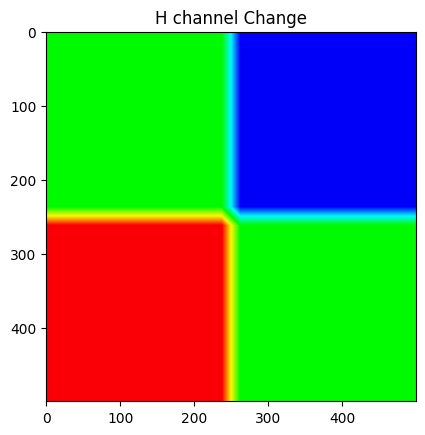

In [19]:
plt.imshow(H_change_res)
plt.title("H channel Change")

In [16]:
s_hsi_img = change_hsi_img('s_channel', s_smoothed)

In [17]:
# 将图像转换回RGB空间
result = cv2.cvtColor(s_hsi_img, cv2.COLOR_HSV2BGR_FULL)
# result = hsi_to_rgb(hsi_img)

Text(0.5, 1.0, 'S channel Change')

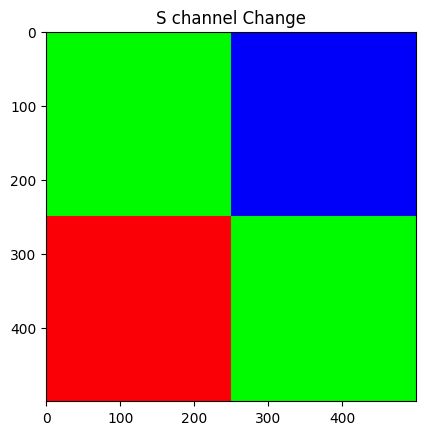

In [20]:
plt.imshow(result)
plt.title("S channel Change")